In [1]:
## Planet: Understanding the Amazon from Space

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *

In [4]:
PATH = 'data/'

In [5]:
os.makedirs('data/models', exist_ok=True)

In [6]:
ls {PATH}

models/              test-jpg-additional/ train_v2.csv
subm/                tmp/
test-jpg/            train-jpg/


In [7]:
## View Data in train and test

In [8]:
from fastai.plots import *

In [9]:
def get_1st(path): return glob(f'{path}/*.*')[0]

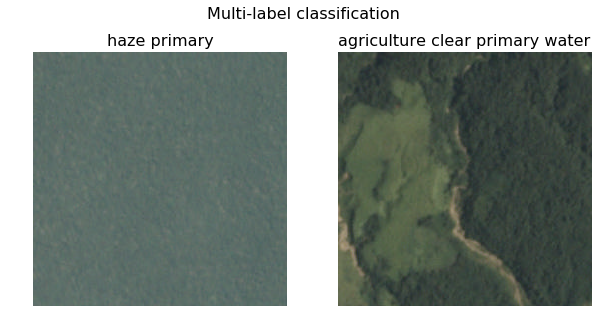

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [11]:
#In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and *water*.

In [12]:
from planet import f2
metrics = [f2]
f_model = resnet34

In [13]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [14]:
#We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [15]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [16]:
data = get_data(256)

In [17]:
x,y = next(iter(data.val_dl))

In [18]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [19]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

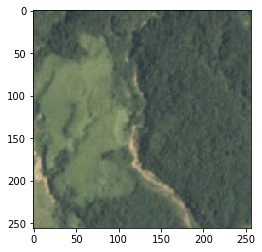

In [20]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.3);

In [21]:
sz=64

In [22]:
data = get_data(sz)

In [38]:
data = data.resize(int(sz*1.3), 'tmp')

In [24]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.225606   0.307603   0.826684  



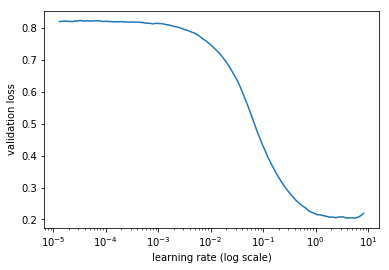

In [25]:
lrf=learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.2

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.149158   0.132524   0.88357   
    1      0.141404   0.126952   0.890062                    
    2      0.139691   0.125207   0.892107                    
    3      0.135167   0.124955   0.891208                    
    4      0.134457   0.123678   0.892609                    
    5      0.133585   0.121694   0.89511                     
    6      0.135742   0.121978   0.894536                    



[array([0.12198]), 0.8945360930867281]

In [28]:
lrs = np.array([lr/9,lr/3,lr])

In [29]:
learn.unfreeze()

In [30]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.122023   0.108833   0.908643  
    1      0.115329   0.104141   0.913305                    
    2      0.105457   0.100208   0.917393                    
    3      0.11328    0.101493   0.915836                    
    4      0.103724   0.09828    0.919437                    
    5      0.10107    0.097276   0.918411                     
    6      0.098611   0.096102   0.919592                     



[array([0.0961]), 0.919592332916522]

In [31]:
learn.save(f'{sz}')

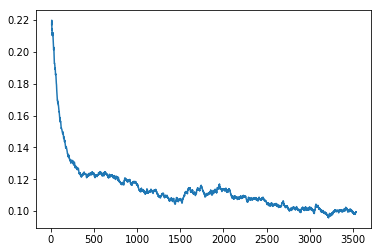

In [32]:
learn.sched.plot_loss()

In [40]:
multi_predcs, y = learn.TTA(is_test=True)

In [41]:
prob = np.mean(np.exp(multi_predcs),0)  # By default, PyTorch models will give you back the log of the predictions, 
# so you need to do np.exp(multi_preds) to get the probability

In [42]:
prob.shape # (n_images, n_classes)

(61191, 17)

In [43]:
df = pd.DataFrame(prob)    # Create Pandas DataFrame

In [44]:
df.head() #view the data stored in data frame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.023342,1.000057,1.000180,1.001262,1.000952,1.000514,1.000110,1.000108,1.012007,1.001560,1.000200,2.716084,2.717973,1.009643,1.000950,1.000859,1.018000
1,2.684397,1.000083,1.009527,1.000148,1.000120,2.709478,1.000122,1.000148,1.099968,1.317627,1.001797,1.002373,2.609385,2.470075,1.000359,1.001679,1.101521
2,1.002687,1.000004,1.000058,1.004059,1.000038,2.717935,1.000008,1.000002,1.000530,1.000703,1.000093,1.000013,2.718181,1.001240,1.000166,1.000021,1.002387
3,1.001436,1.000009,1.000090,1.000293,1.000007,1.046406,1.015267,1.000009,1.000760,1.000373,2.413895,1.000632,2.679735,1.001535,1.000053,1.000020,1.002355
4,1.000758,1.000004,1.000036,1.003326,1.000080,2.716885,1.000054,1.000004,1.000236,1.000373,1.000320,1.000033,2.717866,1.000406,1.000141,1.000015,1.000642


In [45]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

In [46]:
lbls = prob>2  # Getting appropriate labels for each image

In [47]:
lbls  # View how lbls looks

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

['agriculture', 'clear', 'primary', 'road']


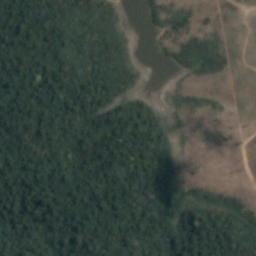

In [60]:
idx=19
print(get_labels(lbls[idx]))
PIL.Image.open(PATH+data.test_dl.dataset.fnames[idx]).convert('RGB')

In [49]:
res = [get_labels(o) for o in lbls]

In [50]:
data.test_dl.dataset.fnames[:5] # View how file names look

['test-jpg/test_21753.jpg',
 'test-jpg/test_30886.jpg',
 'test-jpg/file_13344.jpg',
 'test-jpg/test_11690.jpg',
 'test-jpg/test_9837.jpg']

In [51]:
output = pd.DataFrame({'image_name': [f[9:-4] for f in data.test_dl.dataset.fnames], 'tags': [' '.join(l) for l in res]})

In [52]:
output[:5]

,image_name,tags
0,test_21753,partly_cloudy primary
1,test_30886,agriculture clear primary road
2,file_13344,clear primary
3,test_11690,haze primary
4,test_9837,clear primary


In [53]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
output.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [54]:
FileLink(f'{SUBM}subm.gz')

/Users/setup/OneDrive - SAP SE/Personal Tech Work/FastAI Course/Courses/Planet competition Kaggle/data/subm/subm.gz